--- 

Make sure your python environment has `numpy` and `matplotlib` installed.

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

---
## Simple Box Falling with Contact and Friction

### Physics Equations

**1. Equations of Motion (Newton's Second Law):**
$$
m \vec{a} = \vec{F}_{\text{total}} = \vec{F}_{\text{gravity}} + \vec{F}_{\text{normal}} + \vec{F}_{\text{friction}}
$$

**2. Contact Normal Force (Spring-Damper Model):**
$$
F_n = k \cdot d + c \cdot v_{\text{rel}}
$$
where:
- $d = \max(0, h_{\text{box}} - y)$ is the penetration depth
- $v_{\text{rel}} = -v_y$ is the relative velocity (when in contact)
- $k$ is contact stiffness, $c$ is damping coefficient

**3. Friction Force (Coulomb Friction with Smooth Approximation):**
$$
F_f = -\mu F_n \cdot \tanh(\alpha v_x)
$$
where $\mu$ is the friction coefficient and $\alpha$ controls smoothness

**4. Semi-Implicit Euler Integration:**
$$
\begin{align}
\vec{v}^{(t+1)} &= \vec{v}^{(t)} + \vec{a}^{(t)} \Delta t \\
\vec{x}^{(t+1)} &= \vec{x}^{(t)} + \vec{v}^{(t+1)} \Delta t
\end{align}
$$

---
## Submission
Send your final "falling_box.gif" file to this [GOOGLE FORM](https://forms.gle/3AxEWwi4SEW1dYXT7). 

In [23]:
# ============================================
# HYPERPARAMETERS - Modify these to experiment
# ============================================

# Physical properties
MASS = 1.0                    # Mass of the box (kg)
BOX_SIZE = 0.1                # Half-height of the box (m)
GRAVITY = -9.81               # Gravitational acceleration (m/s^2)

# Contact model parameters
FRICTION_COEFF = 0.3          # Coefficient of friction (dimensionless)
CONTACT_STIFFNESS = 10000     # Contact spring stiffness (N/m)
DAMPING_COEFF = 60           # Contact damping coefficient (N·s/m)

# Simulation parameters
TIME_STEP = 0.001             # Integration time step (s)
NUM_STEPS = 4000              # Number of simulation steps
SAVE_EVERY = 10               # log states for animation every 10 timesteps

# Initial conditions
INITIAL_POS = np.array([0.0, 1.0])   # Initial position [x, y] (m)
INITIAL_VEL = np.array([4.0, 0.0])   # Initial velocity [vx, vy] (m/s)

In [24]:
# ============================================
# SIMULATION LOOP
# ============================================

# Initialize state
pos = INITIAL_POS.copy()
vel = INITIAL_VEL.copy()
positions = []

# Run simulation
for step in range(NUM_STEPS):
    # ===============================
    # TODO: your implementation here
    # ===============================
    # 1. Initialize forces
    F = np.array([0.0, MASS * GRAVITY])  # gravity force
    bottom_y = pos[1] - BOX_SIZE
    penetration = -bottom_y if bottom_y < 0 else 0.0
    if penetration > 0:
    # 2. Compute contact normal force
        v_n = vel[1]
        F_normal = CONTACT_STIFFNESS * penetration - DAMPING_COEFF * v_n
        if F_normal < 0:
            F_normal = 0.0
        F[1] += F_normal
    # 3. Compute friction force
        v_t = vel[0]
        if abs(v_t) < 1e-6 and F_normal > 0:
            F_t_visc = 0.0
        else:
            F_t_visc = -0.02*CONTACT_STIFFNESS * v_t
        
        F_t_limit = FRICTION_COEFF * F_normal
        F_t = max(-F_t_limit, min(F_t_visc, F_t_limit))
        F[0] += F_t

        if pos[1] < -0.05:
            pos[1] = -0.05
    # 4. Semi-implicit Euler integration
    acc = F / MASS
    vel += acc * TIME_STEP
    pos += vel * TIME_STEP

    if step % SAVE_EVERY == 0:  # save every 10 timesteps to run animation faster
        positions.append(pos.copy())

# Convert to numpy array for easier plotting
positions = np.array(positions)
print(f"Simulation completed: {NUM_STEPS} steps")
print(f"Final position: x={positions[-1, 0]:.3f} m, y={positions[-1, 1]:.3f} m")
print(f"Final velocity: vx={vel[0]:.3f} m/s, vy={vel[1]:.3f} m/s")

Simulation completed: 4000 steps
Final position: x=2.987 m, y=0.099 m
Final velocity: vx=0.000 m/s, vy=-0.000 m/s


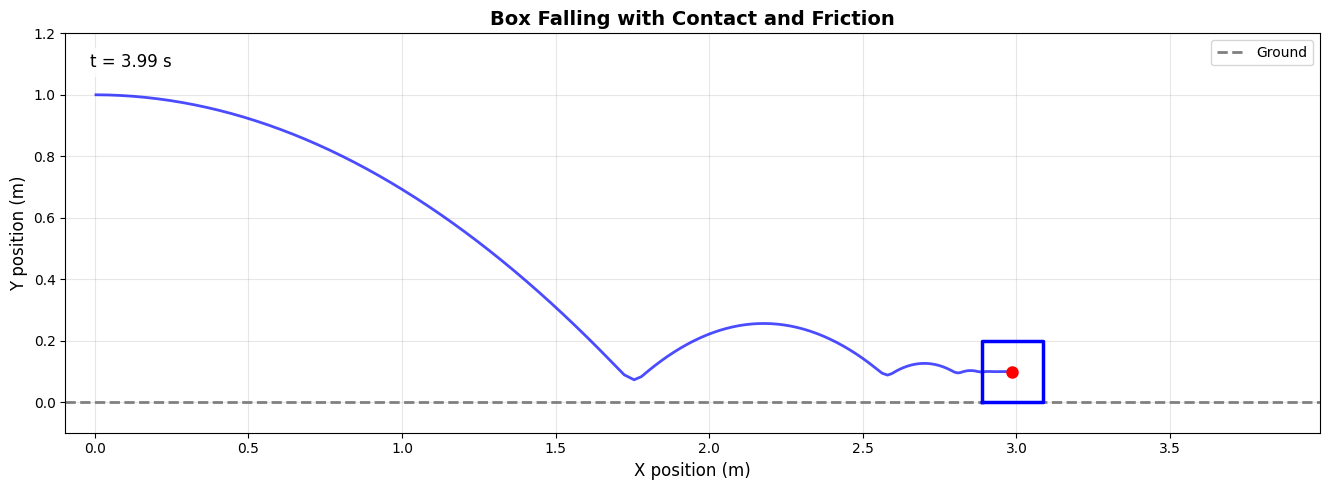

In [25]:
# ============================================
# ANIMATION - Falling Box with Trajectory
# ============================================

# Calculate figure size based on data range
x_range = positions[:, 0].max() - positions[:, 0].min()
y_range = positions[:, 1].max() - positions[:, 1].min()
aspect_ratio = x_range / y_range
# Set height to 5 inches and scale width proportionally
fig_height = 5
fig_width = fig_height * aspect_ratio

# Create figure and axis
fig, ax = plt.subplots(figsize=(fig_width, fig_height))
ax.set_aspect('equal', adjustable='box')
ax.set_xlim(positions[:, 0].min() - 0.1, positions[:, 0].max() + 1.0)
ax.set_ylim(-0.1, 1.2)
ax.axhline(y=0, color='gray', linestyle='--', linewidth=2, label='Ground')
ax.set_xlabel('X position (m)', fontsize=12)
ax.set_ylabel('Y position (m)', fontsize=12)
ax.set_title('Box Falling with Contact and Friction', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)
ax.legend(fontsize=10)

# Create animated elements
trajectory, = ax.plot([], [], 'b-', linewidth=2, label='Trajectory', alpha=0.7)
box_marker, = ax.plot([], [], 'ro', markersize=8, label='Box')
box_patch, = ax.plot([], [], 'b-', lw=2.5, label='Box')
timer_text = ax.text(0.02, 0.95, '', transform=ax.transAxes, fontsize=12, 
                     ha='left', va='top', bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

def init():
    trajectory.set_data([], [])
    box_marker.set_data([], [])
    timer_text.set_text('t = 0.00 s')
    return trajectory, box_marker, timer_text

def animate(i):
    # Update trajectory (show path up to current frame)
    trajectory.set_data(positions[:i+1, 0], positions[:i+1, 1])
    
    # Update box position
    box_marker.set_data([positions[i, 0]], [positions[i, 1]])

    # Update box
    corners_relative = np.array([
        [-BOX_SIZE, -BOX_SIZE],
        [BOX_SIZE, -BOX_SIZE],
        [BOX_SIZE, BOX_SIZE],
        [-BOX_SIZE, BOX_SIZE]
    ])
    corners = positions[i] + corners_relative
    loop = np.vstack([corners, corners[0]])
    box_patch.set_data(loop[:, 0], loop[:, 1])
    
    # Update timer
    time_val = i * TIME_STEP * SAVE_EVERY
    timer_text.set_text(f't = {time_val:.2f} s')
    
    return trajectory, box_marker, timer_text, box_patch

# Create animation
ani = animation.FuncAnimation(
    fig, animate, frames=len(positions),
    init_func=init, blit=True, interval=10
)

# Save animation as GIF
ani.save('falling_box.gif', writer='pillow', fps=30)

plt.tight_layout()
plt.show()